# PyTorch on Mac CIFAR10 TinyVGG Benchmark

> **Note:** As of 21 May 2022, [PyTorch accelerated training for Mac](https://pytorch.org/blog/introducing-accelerated-pytorch-training-on-mac/) is in beta. And is only available through the nightly version of PyTorch.

The following notebook tests the speed at which a given device can perform training iterations on the [CIFAR10 dataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html) (10 classes, 50,000 training images, 10,000 testing images) training the [TinyVGG architecture from the CNN Explainer as a base](https://poloclub.github.io/cnn-explainer/).

It's designed to be a simple test to compare PyTorch compute speeds on Apple Silicon CPU/GPUs.

Ideally, PyTorch runs faster on Apple Silicon GPUs than on Apple Silicon CPUs.

| Model | Dataset | Train Size | Test Size |
| ----- | ----- | ----- | ----- |
| [TinyVGG](https://poloclub.github.io/cnn-explainer/) (trained from scratch) | CIFAR10 (from `torchvision.datasets`) | ~50,000 (32x32x3) images | ~10,000 (32x32x3) images|

## Resources
* Get setup for PyTorch on Apple Silicon: https://github.com/mrdbourke/pytorch-apple-silicon#setup-a-machine-learning-environment-with-pytorch-on-mac-short-version 
* Code in this notebook adapted from: https://www.learnpytorch.io/04_pytorch_custom_datasets/

## 0. Check imports and dependencies

Device name in PyTorch key:

* `"cpu"` - The CPU (Compute Processing Unit) portion of an Apple Silicon chip (M1, M1 Pro, M1 Max, M1 Ultra).
* `"mps"` - The GPU (Graphics Processing Unit) portion of an Apple Silicon chip (M1, M1 Pro, M1 Max, M1 Ultra). 
    * MPS stands for *Metal Performance Shader* which is part of [Apple's GPU framework Metal](https://developer.apple.com/metal/). 

Generally, deep neural networks compute faster on the GPU, that's what this notebook aims to inspect. 

See more for using the MPS backend in the [PyTorch documentation](https://pytorch.org/docs/master/notes/mps.html?highlight=mac).

In [1]:
import torch
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

PyTorch version: 1.13.0.dev20220522
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


## Setup Hyperparameters and Helper Functions

In [2]:
# Setup hyperparameters
BATCH_SIZE = 32 # good for your health: https://twitter.com/ylecun/status/989610208497360896
IMAGE_SIZE = (224, 224) # (height, width) smaller images means faster computing 
NUM_EPOCHS = 3 # only run for a short period of time... we don't have all day
DATASET_NAME = "cifar10" # dataset to use (there are more in torchvision.datasets)
MACHINE = "Apple M1 Pro" # change this depending on where you're runing the code
NUM_WORKERS = 2 # set number of cores to load data

In [3]:
from timeit import default_timer as timer 

def print_train_time(start, end, device=None, machine=None):
    """Prints difference between start and end time.
    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    if device:  
        print(f"\nTrain time on {machine} using PyTorch device {device}: {total_time:.3f} seconds\n")
    else:
        print(f"\nTrain time: {total_time:.3f} seconds\n")
    return round(total_time, 3)

## 1. Get data

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
    transforms.Resize(size=IMAGE_SIZE),
    transforms.ToTensor()
])

# Get Datasets
train_data = datasets.CIFAR10(root="data",
                              train=True,
                              transform=simple_transform,
                              download=True)

test_data = datasets.CIFAR10(root="data",
                             train=False,
                             transform=simple_transform,
                             download=True)

print(f"Number of training samples: {len(train_data)}, number of testing samples: {len(test_data)}")

# Create DataLoaders
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS,
                              pin_memory=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS,
                             pin_memory=True)

train_dataloader, test_dataloader

Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 50000, number of testing samples: 10000


(<torch.utils.data.dataloader.DataLoader at 0x15b13f340>,
 <torch.utils.data.dataloader.DataLoader at 0x15b13f1f0>)

In [5]:
train_data[0][0].shape

torch.Size([3, 224, 224])

In [6]:
# Get class names
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Now we've got some data let's write some code to view the images.

In [7]:
# Take in a Dataset as well as a list of class names
import random
from typing import List
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # Set random seed
    if seed:
        random.seed(seed)

    # Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # Setup plot
    plt.figure(figsize=(16, 8))

    # Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

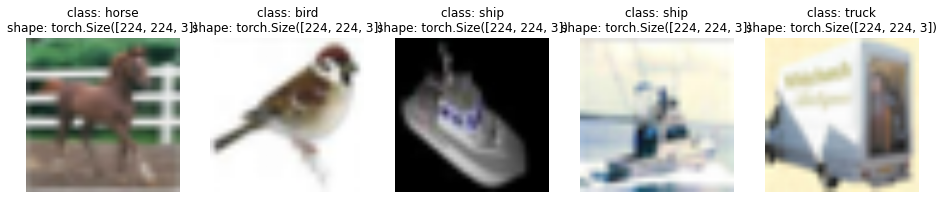

In [8]:
# Display random images
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

# 2. Create model

TinyVGG architecture from CNN Explainer website: https://poloclub.github.io/cnn-explainer/

In [9]:
import torch
from torch import nn
class TinyVGG(nn.Module):
    """Creates the TinyVGG architecture.

    Replicates the TinyVGG architecture from the CNN explainer website in PyTorch.
    See the original architecture here: https://poloclub.github.io/cnn-explainer/

    Args:
    input_shape: An integer indicating number of input channels.
    hidden_units: An integer indicating number of hidden units between layers.
    output_shape: An integer indicating number of output units.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=0),  
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
          )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
#             nn.Linear(in_features=hidden_units*5*5,out_features=output_shape) # image shape 32, 32
            nn.Linear(in_features=hidden_units*53*53,out_features=output_shape) # image shape 224, 224
        )

    def forward(self, x: torch.Tensor):
# #         print(x.shape)
#         x = self.conv_block_1(x)
# #         print(x.shape)
#         x = self.conv_block_2(x)
# #         print(x.shape)
#         x = self.classifier(x)
#         return x
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [10]:
# Do a dummy forward pass (to test the model) 
model = TinyVGG(input_shape=3,
               hidden_units=10,
               output_shape=3)

model(torch.randn(1, 3, 224, 224))

tensor([[ 0.0002, -0.0138,  0.0061]], grad_fn=<AddmmBackward0>)

## 3. Setup training/testing loop(s)

In [11]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
#         X, y = X.to(device, non_blocking=True, memory_format=torch.channels_last), y.to(device, non_blocking=True)
#         X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        
    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [12]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
#             X, y = X.to(device, non_blocking=True, memory_format=torch.channels_last), y.to(device, non_blocking=True)
#             X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [13]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device):
    
    print(f"[INFO] Training model {model.__class__.__name__} on device '{device}' for {epochs} epochs...")
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
#     for epoch in range(epochs):
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

## 4. Train the model on CPU and MPS device (GPU)

In [ ]:
# Set random seed
torch.manual_seed(42)

# Create device list
devices = ["cpu", "mps"]

for device in devices:

    # Recreate an instance of TinyVGG
    model = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                    hidden_units=10, 
                    output_shape=len(train_data.classes)).to(device)

    # Setup loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

    # Start the timer
    from timeit import default_timer as timer 
    start_time = timer()

    # Train model
    model_results = train(model=model, 
                          train_dataloader=train_dataloader,
                          test_dataloader=test_dataloader,
                          optimizer=optimizer,
                          loss_fn=loss_fn, 
                          epochs=NUM_EPOCHS,
                          device=device)

    # End the timer
    end_time = timer()

    # Print out timer and results
    total_train_time = print_train_time(start=start_time,
                                        end=end_time,
                                        device=device,
                                        machine=MACHINE)
    
    # Create results dict
    results = {
    "machine": MACHINE,
    "device": device,
    "dataset_name": DATASET_NAME,
    "epochs": NUM_EPOCHS,
    "batch_size": BATCH_SIZE,
    "image_size": IMAGE_SIZE[0],
    "num_train_samples": len(train_data),
    "num_test_samples": len(test_data),
    "total_train_time": round(total_train_time, 3),
    "time_per_epoch": round(total_train_time/NUM_EPOCHS, 3),
    "model": model.__class__.__name__
    }
    
    results_df = pd.DataFrame(results, index=[0])
    
    # Write CSV to file
    import os
    if not os.path.exists("results/"):
        os.makedirs("results/")

    results_df.to_csv(f"results/{MACHINE.lower().replace(' ', '_')}_{device}_{DATASET_NAME}.csv", 
                      index=False)

[INFO] Training model TinyVGG on device 'cpu' for 3 epochs...


  0%|          | 0/3 [00:00<?, ?it/s]

## 5. Inspect results

In [ ]:
# Get CSV paths from results
from pathlib import Path
results_paths = list(Path("results").glob("*.csv"))

df_list = []
for path in results_paths:
    df_list.append(pd.read_csv(path))
results_df = pd.concat(df_list).reset_index(drop=True)
results_df

In [ ]:
# Get names of devices
machine_and_device_list = [row[1][0] + " (" + row[1][1] + ")" for row in results_df[["machine", "device"]].iterrows()]

# Plot and save figure
plt.figure(figsize=(10, 7))
plt.style.use('fivethirtyeight')
plt.bar(machine_and_device_list, height=results_df.time_per_epoch)
plt.title(f"PyTorch TinyVGG Training on CIFAR10 with batch size {BATCH_SIZE} and image size {IMAGE_SIZE}", size=16)
plt.xlabel("Machine (device)", size=14)
plt.ylabel("Seconds per epoch (lower is better)", size=14);
save_path = f"results/{model.__class__.__name__}_{DATASET_NAME}_benchmark_with_batch_size_{BATCH_SIZE}_image_size_{IMAGE_SIZE[0]}.png"
print(f"Saving figure to '{save_path}'")
plt.savefig(save_path)